In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from copy import copy
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import contractions


#### Loading Data

In [2]:
with open('/kaggle/input/presidential-debate-2-transcript2024/Presidential_Debate_2_Transcript.txt', 'r') as file:
    text_data = file.read()
    
print(f"Length of transcript text: {len(text_data)}")

Length of transcript text: 95436


#### Let's take glimpse of the data

In [3]:
text_data[:1000]

"PARTICIPANTS: Vice President Kamala Harris (D) and Former President Donald Trump (R)\n\nMODERATORS: Linsey Davis (ABC News) and David Muir (ABC News)\n\nMUIR:  Good evening, I'm David Muir. And thank you for joining us for tonight's ABC News Presidential Debate. We want to welcome viewers watching on ABC and around the world tonight. Vice President Kamala Harris and President Donald Trump are just moments away from taking the stage in this unprecedented race for president.\n\nDAVIS:  And I'm Linsey Davis. Tonight's meeting could be the most consequential event of their campaigns, with Election Day now less than two months away. For Vice President Kamala Harris, this is her first debate since President Biden withdrew from the race on July 21st. Of course, that decision followed his debate against President Donald Trump in June. Since then, this race has taken on an entirely new dynamic.\n\nMUIR:  And that brings us to the rules of tonight's debate: 90 minutes with two commercial breaks

### Let's explore the data and answer the following questions:
#### 1. Number of times each participant has spoken
#### 2. Most used words in the debate

paragraphs: 221


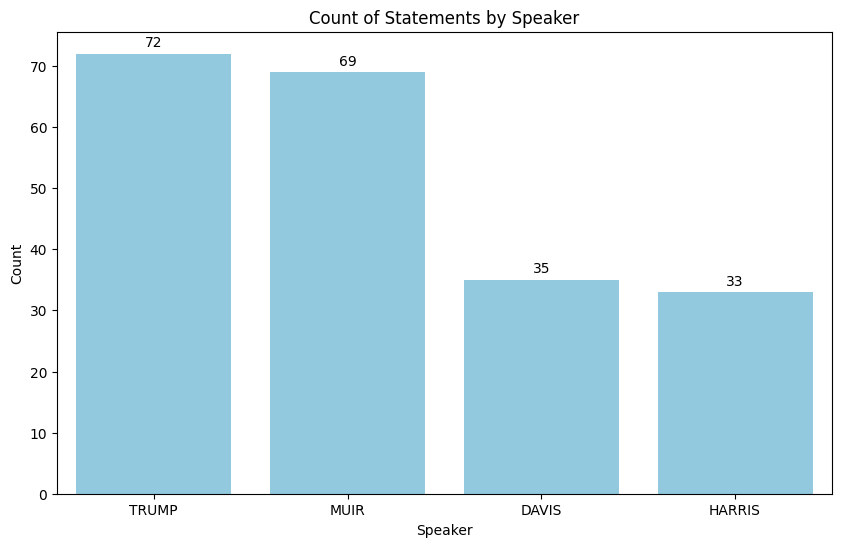

In [4]:
regex_list = ["TRUMP:", "HARRIS:", "MUIR:", "DAVIS:"]
group = 0
counts = {}

# Split the text into paragraphs
texts = text_data.split("\n\n")
print(f"paragraphs: {len(texts)}")

# Count occurrences of each speaker
for regex in regex_list:
    count = 0
    for text in texts:
        regex_pattern = re.compile(regex, re.UNICODE)
        results = [match.group(group) for match in regex_pattern.finditer(text)]
        count += len(results)
    speaker = regex.rstrip(':')
    counts[speaker] = count
    

# Create a DataFrame for visualization
df = pd.DataFrame(list(counts.items()), columns=['Speaker', 'Count'])
df = df.sort_values(by='Count', ascending=False)


plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Speaker', y='Count', data=df, color='skyblue')  # Set bar color to skyblue

# Add counts at the top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center',
                xytext = (0, 8), 
                textcoords = 'offset points')

plt.title('Count of Statements by Speaker')
plt.xlabel('Speaker')
plt.ylabel('Count')
plt.show()

### What are the most used words in the debate

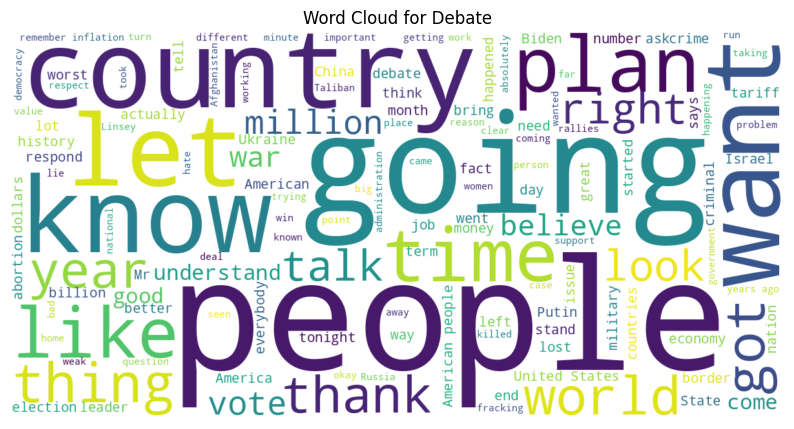

In [5]:
# Define stopwords 
stopwords = set(STOPWORDS)
custom_stopwords = {'said', 'one', 'will','President','HARRIS','DAVIS','MUIR','LINDSEY','Donald','president','Trump','Harris','Vice','David'}  # Add any other common words you want to exclude
stopwords.update(custom_stopwords)

# Function to expand contractions
def expand_contractions(text_data):
    return contractions.fix(text_data)

# Function to generate and plot word cloud with a custom image as background (optional)
def plot_wordcloud(text_data, title='Word Cloud'):
    
    wordcloud = WordCloud(
        background_color='white',
        contour_color='black',
        contour_width=1,
        stopwords=stopwords,
        max_words=500,
        max_font_size=80,
        scale=3,
        random_state=1
    ).generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

    

# Expand contractions in the text
text = expand_contractions(text_data)
    
    # Generate and display the word cloud
plot_wordcloud(text_data, 'Word Cloud for Debate')


##### top 10 words for trump and harris

Top 10 words for Trump:
{'people': 76, 'going': 63, 'country': 50, 'know': 31, 'got': 29, 'president': 28, 'never': 27, 'look': 26, 'years': 23, 'now': 23}

Top 10 words for Harris:
{'president': 51, 'people': 47, 'trump': 37, 'donald': 31, 'let': 26, 'american': 25, 'plan': 20, 'know': 20, 'states': 19, 'united': 18}

Top 10 nouns and proper nouns for Trump:
{'people': 76, 'country': 50, 'president': 28, 'years': 23, 'world': 21, 'things': 18, 'plan': 17, 'millions': 16, 'war': 15, 'biden': 14}

Top 10 nouns and proper nouns for Harris:
{'president': 51, 'people': 47, 'trump': 37, 'donald': 31, 'plan': 20, 'states': 19, 'united': 18, 'america': 16, 'time': 13, 'care': 11}

Top 10 adjectives for Trump:
{'good': 20, 'many': 16, 'bad': 12, 'worst': 9, 'great': 9, 'different': 9, 'big': 8, 'higher': 7, 'afraid': 7, 'better': 6}

Top 10 adjectives for Harris:
{'american': 24, 'former': 15, 'clear': 9, 'small': 7, 'first': 7, 'affordable': 7, 'young': 6, 'important': 6, 'middle': 5, 'many':

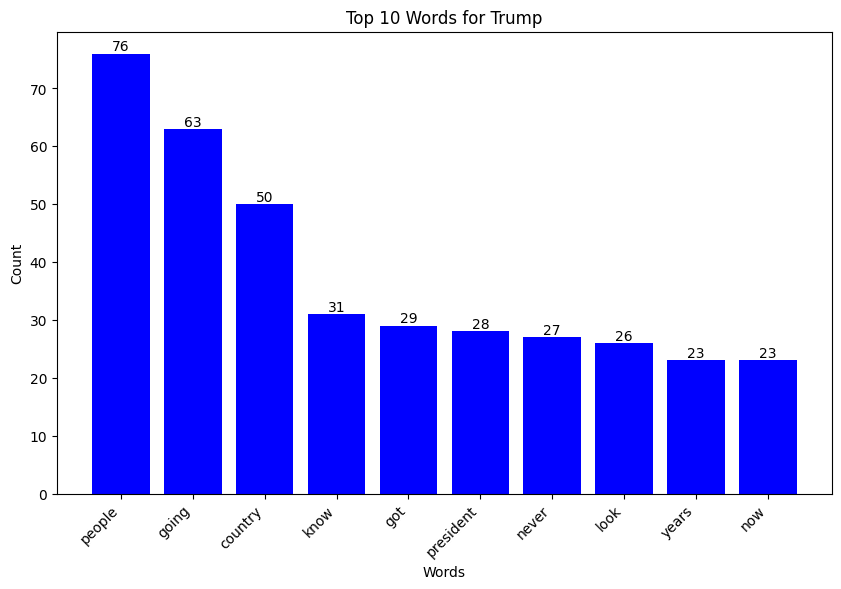

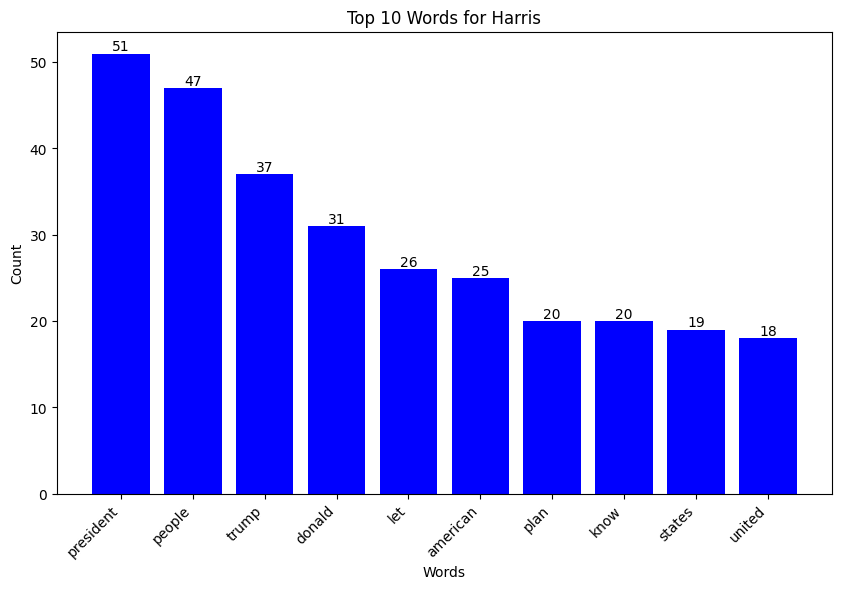

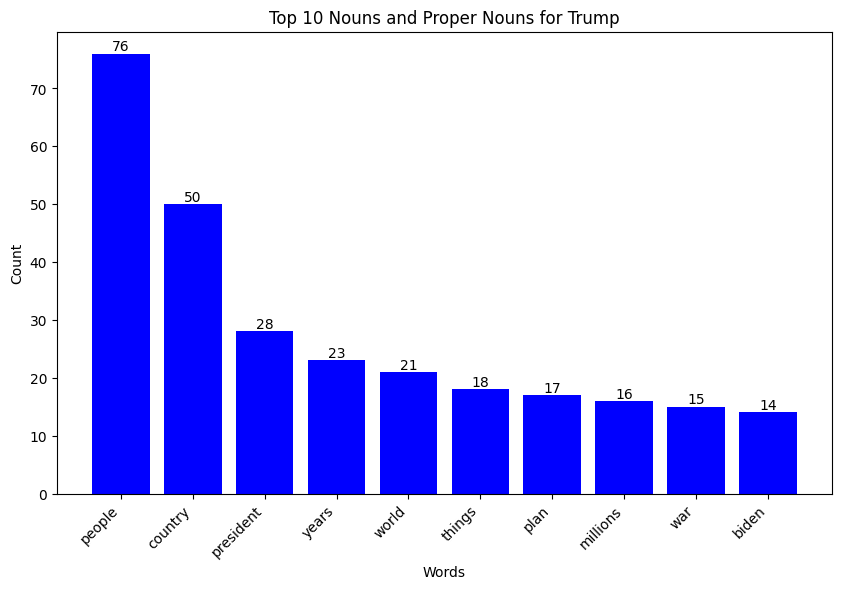

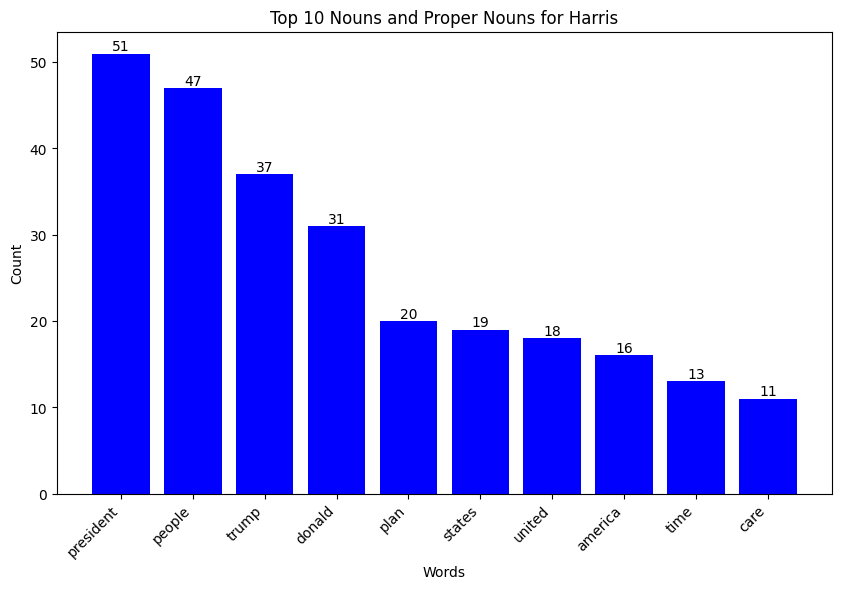

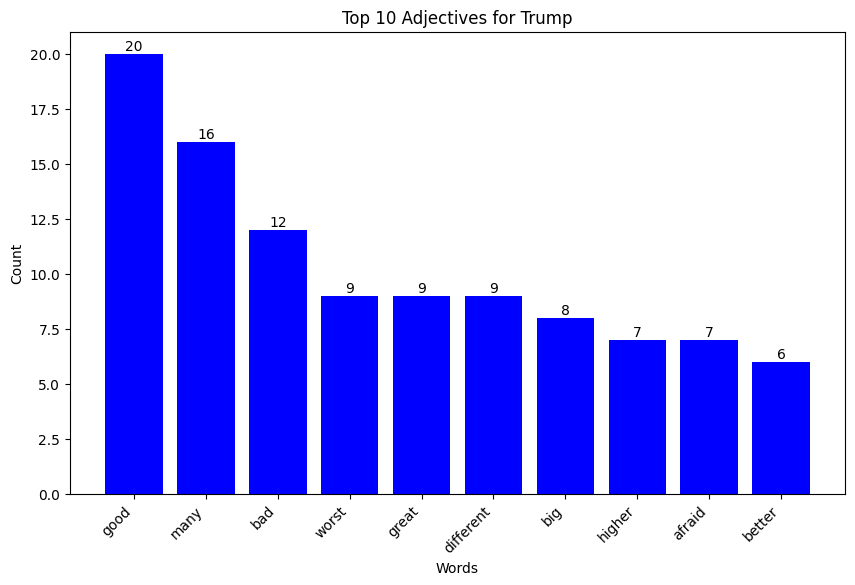

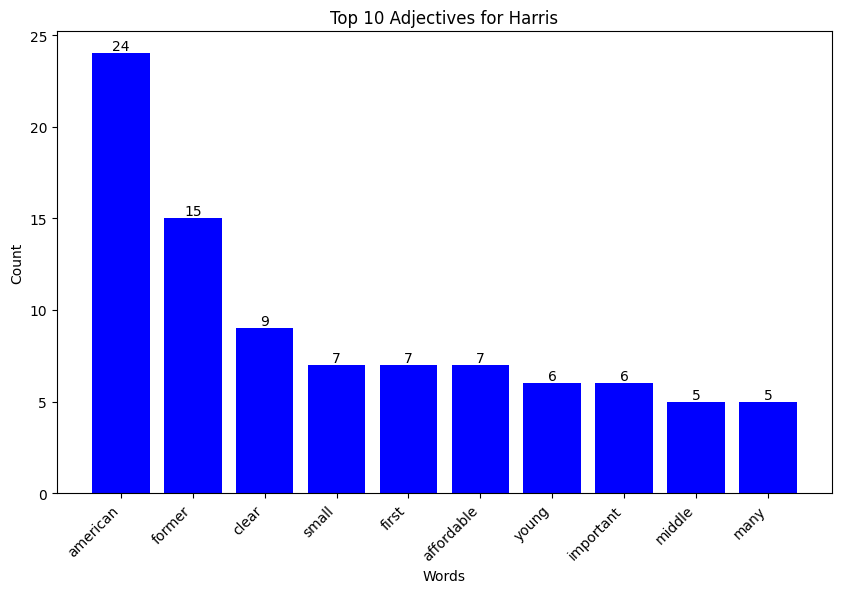

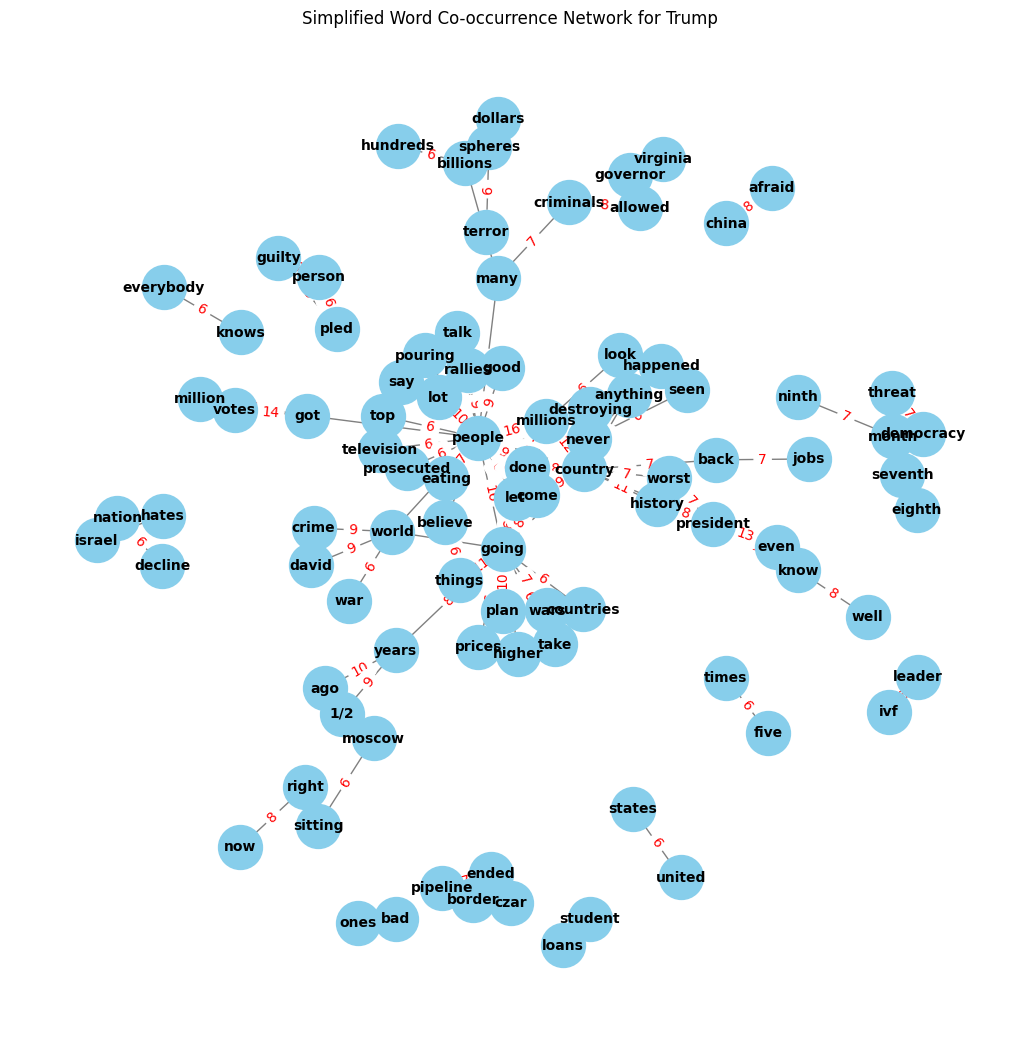

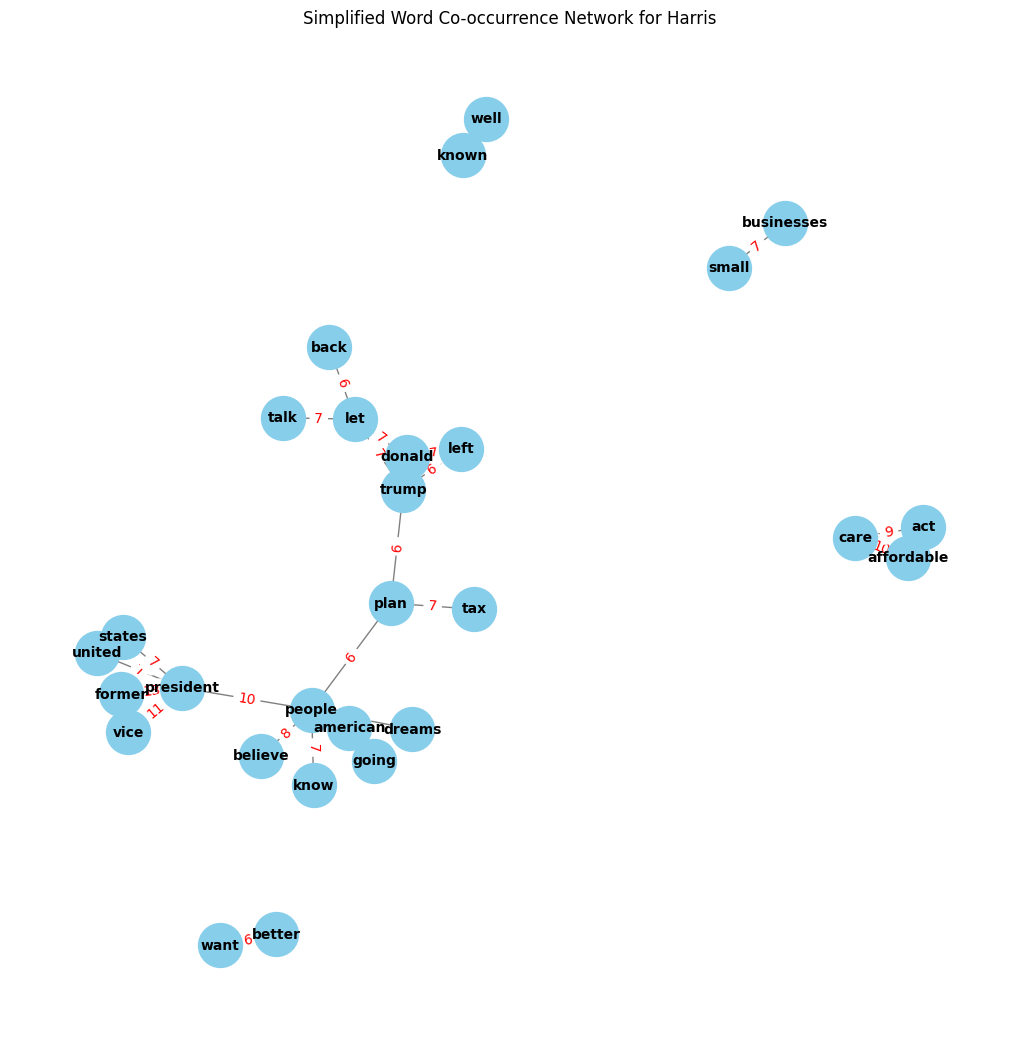

In [6]:
import re
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import contractions
import spacy
import networkx as nx
from wordcloud import STOPWORDS

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Define stopwords and add custom stopwords
stopwords = set(STOPWORDS)
custom_stopwords = {'said', 'one', 'will'}
stopwords.update(custom_stopwords)

# Function to read text from a file
def read_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Function to extract text for a specific speaker
def extract_text_for_speaker(text, speaker):
    pattern = re.compile(rf'{speaker}: (.*?)(?:\n[A-Z]+:|\n\n|$)', re.DOTALL)
    matches = pattern.findall(text)
    return ' '.join(matches)

# Function to expand contractions and count words
def count_words(text):
    expanded_text = contractions.fix(text)
    words = re.findall(r'\b\w{3,}\b', expanded_text.lower())
    word_counts = Counter(words)
    filtered_counts = {word: count for word, count in word_counts.items() if word not in stopwords}
    return dict(Counter(filtered_counts).most_common(10))

# Function to extract and count nouns, proper nouns, and adjectives
def count_pos(text, pos_tags):
    doc = nlp(text)
    pos_counts = Counter()
    for token in doc:
        if token.pos_ in pos_tags and token.text.lower() not in stopwords and len(token.text) > 2:
            pos_counts[token.text.lower()] += 1
    return dict(Counter(pos_counts).most_common(10))

# Function to compute word co-occurrences
def count_word_cooccurrences(text, window_size=5):
    expanded_text = contractions.fix(text)
    doc = nlp(expanded_text)
    tokens = [token.text.lower() for token in doc if token.text.lower() not in stopwords and len(token.text) > 2]
    cooccurrence_counts = defaultdict(Counter)
    for i, word in enumerate(tokens):
        window = tokens[max(0, i - window_size):i] + tokens[i + 1:i + 1 + window_size]
        for neighbor in window:
            if word != neighbor:
                cooccurrence_counts[word][neighbor] += 1
    return cooccurrence_counts

# Function to plot word counts
def plot_word_counts(word_counts, title):
    df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])
    df = df.sort_values(by='Count', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(df['Word'], df['Count'], color='blue')
    plt.xlabel('Words')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    for i, (word, count) in enumerate(zip(df['Word'], df['Count'])):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.show()

# Function to plot a simplified co-occurrence network graph
def plot_simplified_cooccurrence_network(cooccurrence_counts, title, threshold=5):
    G = nx.Graph()
    for word, neighbors in cooccurrence_counts.items():
        for neighbor, count in neighbors.items():
            if count > threshold:
                G.add_edge(word, neighbor, weight=count)
    
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title(title)
    plt.show()

# Main function to process the debate text
def process_debate(file_path):
    text = read_text(file_path)
    
    trump_text = extract_text_for_speaker(text, 'TRUMP')
    harris_text = extract_text_for_speaker(text, 'HARRIS')
    
    trump_word_counts = count_words(trump_text)
    harris_word_counts = count_words(harris_text)
    
    trump_nouns = count_pos(trump_text, {'NOUN', 'PROPN'})
    harris_nouns = count_pos(harris_text, {'NOUN', 'PROPN'})
    
    trump_adjectives = count_pos(trump_text, {'ADJ'})
    harris_adjectives = count_pos(harris_text, {'ADJ'})
    
    trump_cooccurrences = count_word_cooccurrences(trump_text)
    harris_cooccurrences = count_word_cooccurrences(harris_text)
    
    print("Top 10 words for Trump:")
    print(trump_word_counts)
    
    print("\nTop 10 words for Harris:")
    print(harris_word_counts)
    
    print("\nTop 10 nouns and proper nouns for Trump:")
    print(trump_nouns)
    
    print("\nTop 10 nouns and proper nouns for Harris:")
    print(harris_nouns)
    
    print("\nTop 10 adjectives for Trump:")
    print(trump_adjectives)
    
    print("\nTop 10 adjectives for Harris:")
    print(harris_adjectives)
    
    plot_word_counts(trump_word_counts, 'Top 10 Words for Trump')
    plot_word_counts(harris_word_counts, 'Top 10 Words for Harris')

    plot_word_counts(trump_nouns, 'Top 10 Nouns and Proper Nouns for Trump')
    plot_word_counts(harris_nouns, 'Top 10 Nouns and Proper Nouns for Harris')

    plot_word_counts(trump_adjectives, 'Top 10 Adjectives for Trump')
    plot_word_counts(harris_adjectives, 'Top 10 Adjectives for Harris')

    plot_simplified_cooccurrence_network(trump_cooccurrences, 'Simplified Word Co-occurrence Network for Trump')
    plot_simplified_cooccurrence_network(harris_cooccurrences, 'Simplified Word Co-occurrence Network for Harris')

# Replace with the path to your file
file_path = '/kaggle/input/presidential-debate-2-transcript2024/Presidential_Debate_2_Transcript.txt'
process_debate(file_path)


Top 10 words for Trump:
{'people': 76, 'going': 63, 'country': 50, 'know': 31, 'got': 29, 'president': 28, 'never': 27, 'look': 26, 'years': 23, 'now': 23}

Top 10 words for Harris:
{'president': 51, 'people': 47, 'trump': 37, 'donald': 31, 'let': 26, 'american': 25, 'plan': 20, 'know': 20, 'states': 19, 'united': 18}

Top 10 nouns and proper nouns for Trump:
{'people': 76, 'country': 50, 'president': 28, 'years': 23, 'world': 21, 'things': 18, 'plan': 17, 'millions': 16, 'war': 15, 'biden': 14}

Top 10 nouns and proper nouns for Harris:
{'president': 51, 'people': 47, 'trump': 37, 'donald': 31, 'plan': 20, 'states': 19, 'united': 18, 'america': 16, 'time': 13, 'care': 11}

Top 10 adjectives for Trump:
{'good': 20, 'many': 16, 'bad': 12, 'worst': 9, 'great': 9, 'different': 9, 'big': 8, 'higher': 7, 'afraid': 7, 'better': 6}

Top 10 adjectives for Harris:
{'american': 24, 'former': 15, 'clear': 9, 'small': 7, 'first': 7, 'affordable': 7, 'young': 6, 'important': 6, 'middle': 5, 'many':

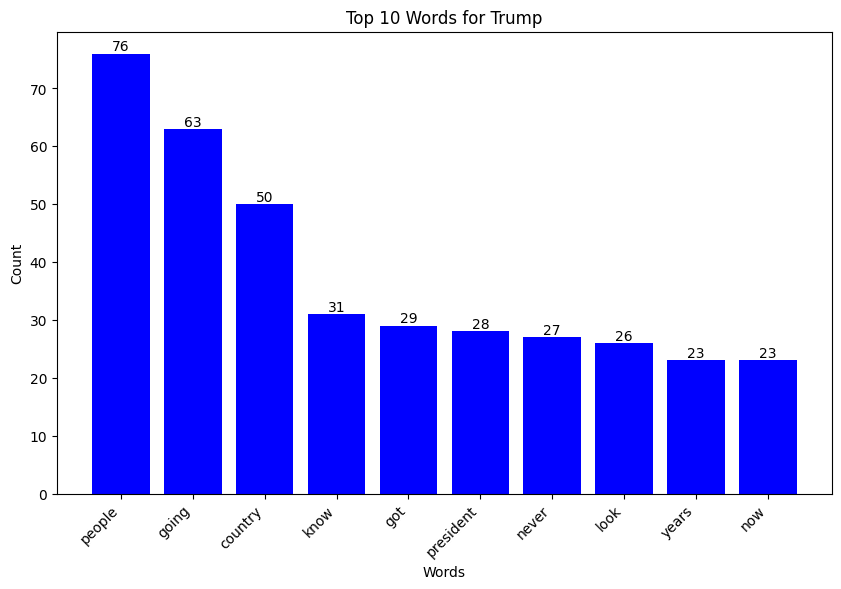

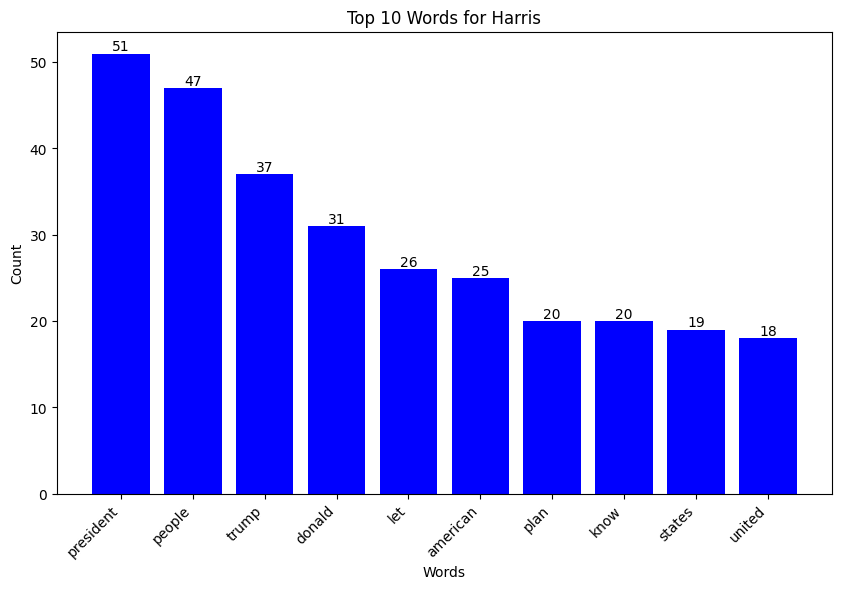

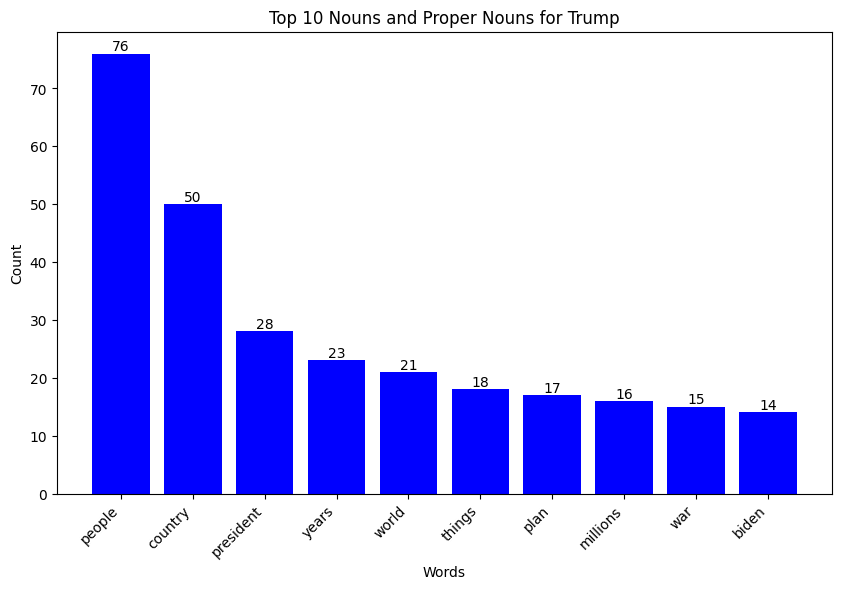

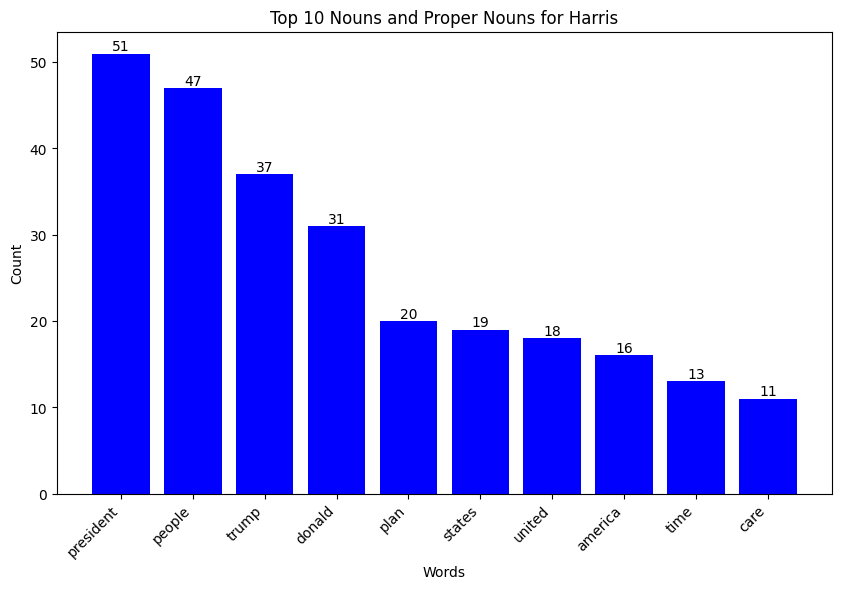

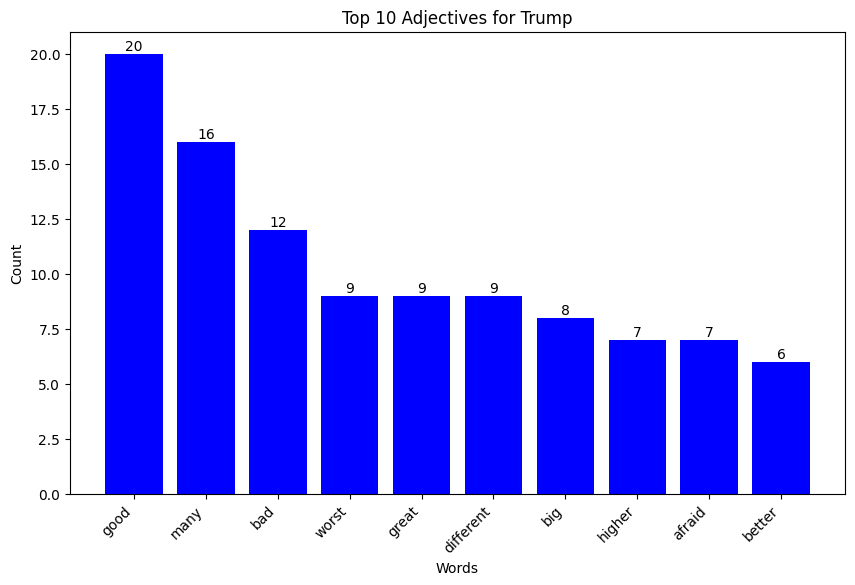

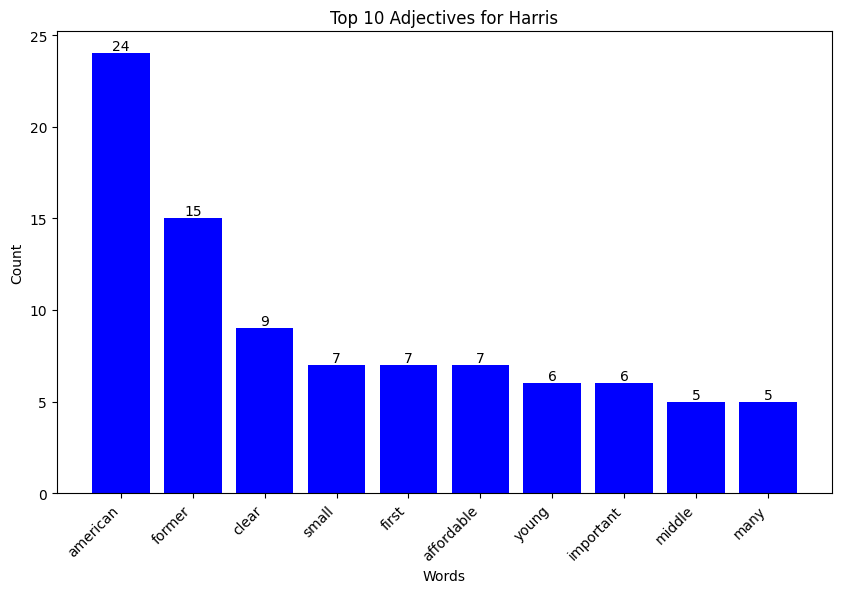

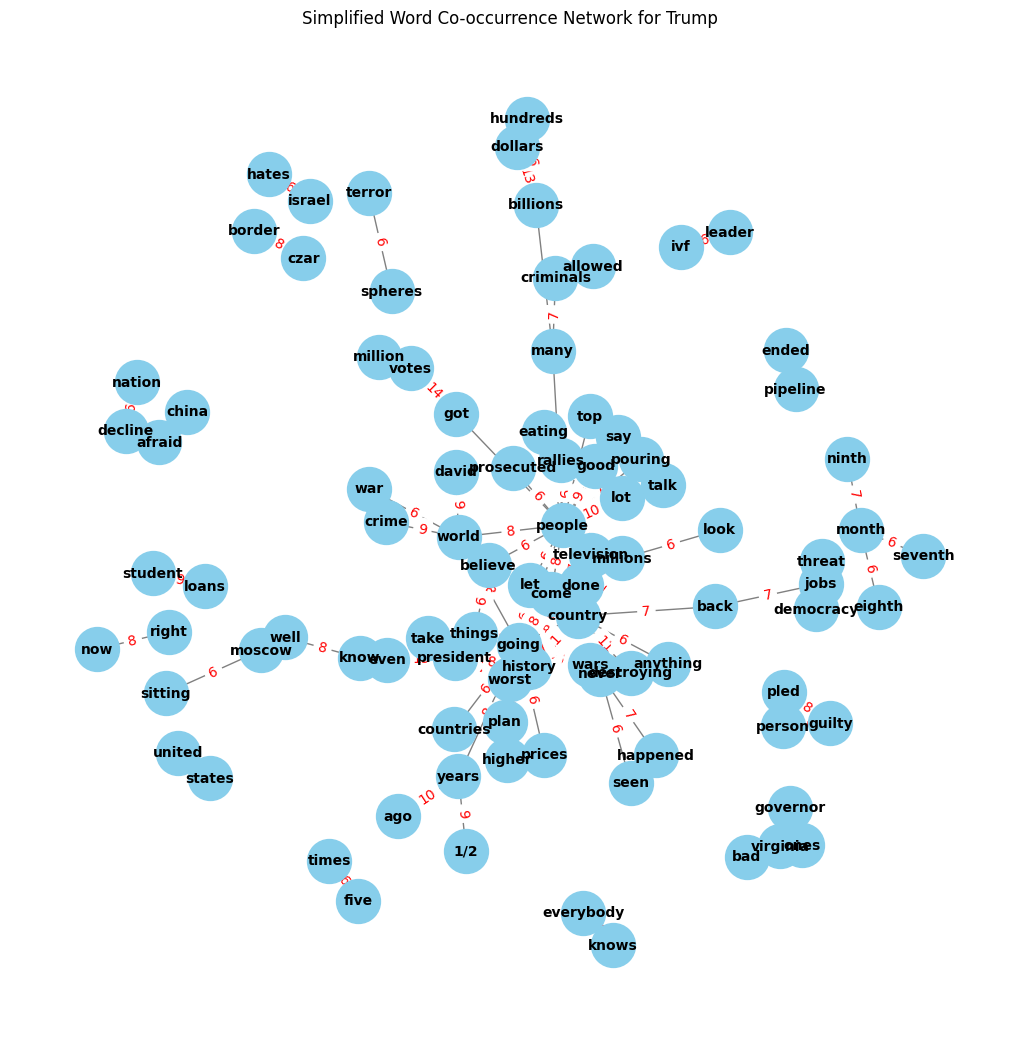

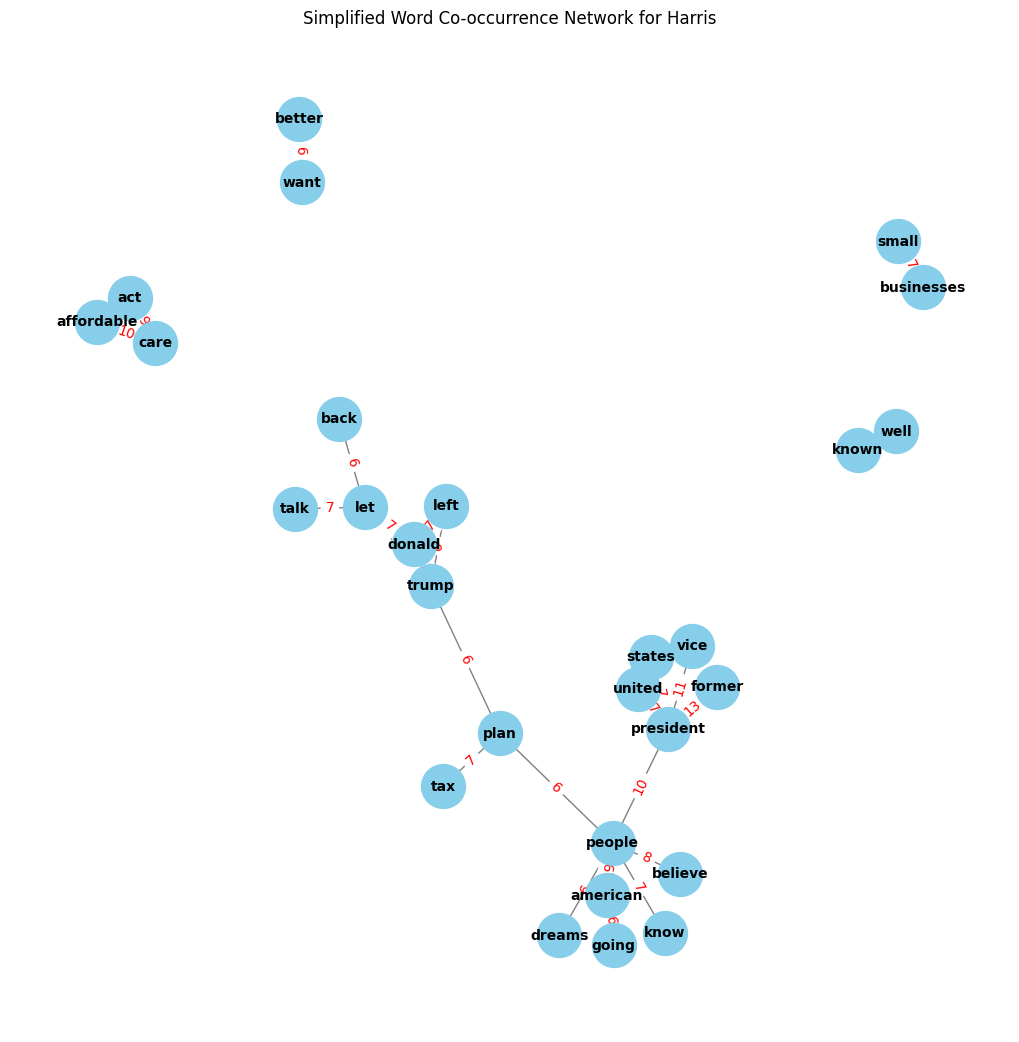

In [7]:
import re
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import networkx as nx
import numpy as np
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Define stopwords and add custom stopwords
stopwords = set(STOPWORDS)
custom_stopwords = {'said', 'one', 'will','President','Trump','PRESIDENT','Vice','MUIR','DAVID','HARRIS'}
stopwords.update(custom_stopwords)

# Function to expand contractions using the contractions library
def expand_contractions(text):
    return contractions.fix(text)

# Function to read text from a file
def read_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Function to extract text for a specific speaker
def extract_text_for_speaker(text, speaker):
    pattern = re.compile(rf'{speaker}: (.*?)(?:\n[A-Z]+:|\n\n|$)', re.DOTALL)
    matches = pattern.findall(text)
    return ' '.join(matches)

# Function to expand contractions and count words
def count_words(text):
    expanded_text = expand_contractions(text)
    words = re.findall(r'\b\w{3,}\b', expanded_text.lower())
    word_counts = Counter(words)
    filtered_counts = {word: count for word, count in word_counts.items() if word not in stopwords}
    return dict(Counter(filtered_counts).most_common(10))

# Function to extract and count nouns, proper nouns, and adjectives
def count_pos(text, pos_tags):
    doc = nlp(text)
    pos_counts = Counter()
    for token in doc:
        if token.pos_ in pos_tags and token.text.lower() not in stopwords and len(token.text) > 2:
            pos_counts[token.text.lower()] += 1
    return dict(Counter(pos_counts).most_common(10))

# Function to compute word co-occurrences
def count_word_cooccurrences(text, window_size=5):
    expanded_text = expand_contractions(text)
    doc = nlp(expanded_text)
    tokens = [token.text.lower() for token in doc if token.text.lower() not in stopwords and len(token.text) > 2]
    cooccurrence_counts = defaultdict(Counter)
    for i, word in enumerate(tokens):
        window = tokens[max(0, i - window_size):i] + tokens[i + 1:i + 1 + window_size]
        for neighbor in window:
            if word != neighbor:
                cooccurrence_counts[word][neighbor] += 1
    return cooccurrence_counts

# Function to compute word correlation
def compute_word_correlation(text):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform([text])
    Xc = (X.T * X)  # Compute term-document matrix
    Xc.setdiag(0)  # Remove self-correlation
    correlations = np.array(Xc.toarray())
    word_names = vectorizer.get_feature_names_out()
    
    # Create a dictionary for correlations
    correlation_dict = defaultdict(dict)
    for i, word1 in enumerate(word_names):
        for j, word2 in enumerate(word_names):
            if i != j:
                correlation_dict[word1][word2] = correlations[i, j]
    
    return correlation_dict

# Function to plot word counts
def plot_word_counts(word_counts, title):
    df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])
    df = df.sort_values(by='Count', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(df['Word'], df['Count'], color='blue')
    plt.xlabel('Words')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    for i, (word, count) in enumerate(zip(df['Word'], df['Count'])):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.show()

# Function to plot a simplified co-occurrence network graph
def plot_simplified_cooccurrence_network(cooccurrence_counts, title, threshold=5):
    G = nx.Graph()
    for word, neighbors in cooccurrence_counts.items():
        for neighbor, count in neighbors.items():
            if count > threshold:
                G.add_edge(word, neighbor, weight=count)
    
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title(title)
    plt.show()


# Main function to process the debate text
def process_debate(file_path):
    text = read_text(file_path)
    
    trump_text = extract_text_for_speaker(text, 'TRUMP')
    harris_text = extract_text_for_speaker(text, 'HARRIS')
    
    trump_word_counts = count_words(trump_text)
    harris_word_counts = count_words(harris_text)
    
    trump_nouns = count_pos(trump_text, {'NOUN', 'PROPN'})
    harris_nouns = count_pos(harris_text, {'NOUN', 'PROPN'})
    
    trump_adjectives = count_pos(trump_text, {'ADJ'})
    harris_adjectives = count_pos(harris_text, {'ADJ'})
    
    trump_cooccurrences = count_word_cooccurrences(trump_text)
    harris_cooccurrences = count_word_cooccurrences(harris_text)
    
    trump_correlation = compute_word_correlation(trump_text)
    harris_correlation = compute_word_correlation(harris_text)
    
    print("Top 10 words for Trump:")
    print(trump_word_counts)
    
    print("\nTop 10 words for Harris:")
    print(harris_word_counts)
    
    print("\nTop 10 nouns and proper nouns for Trump:")
    print(trump_nouns)
    
    print("\nTop 10 nouns and proper nouns for Harris:")
    print(harris_nouns)
    
    print("\nTop 10 adjectives for Trump:")
    print(trump_adjectives)
    
    print("\nTop 10 adjectives for Harris:")
    print(harris_adjectives)
    
    plot_word_counts(trump_word_counts, 'Top 10 Words for Trump')
    plot_word_counts(harris_word_counts, 'Top 10 Words for Harris')

    plot_word_counts(trump_nouns, 'Top 10 Nouns and Proper Nouns for Trump')
    plot_word_counts(harris_nouns, 'Top 10 Nouns and Proper Nouns for Harris')

    plot_word_counts(trump_adjectives, 'Top 10 Adjectives for Trump')
    plot_word_counts(harris_adjectives, 'Top 10 Adjectives for Harris')

    plot_simplified_cooccurrence_network(trump_cooccurrences, 'Simplified Word Co-occurrence Network for Trump')
    plot_simplified_cooccurrence_network(harris_cooccurrences, 'Simplified Word Co-occurrence Network for Harris')



# Replace with the path to your file
file_path = '/kaggle/input/presidential-debate-2-transcript2024/Presidential_Debate_2_Transcript.txt'
process_debate(file_path)


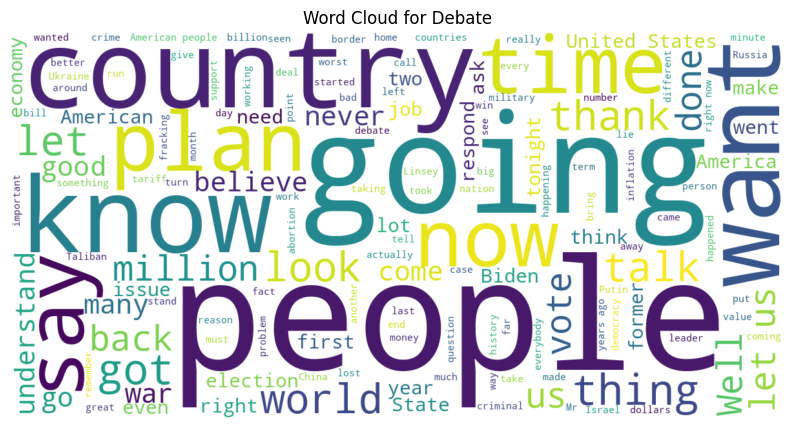

In [8]:
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import numpy as np
import contractions  # Ensure you have this library installed

# Define stopwords and add custom stopwords
stopwords = set(STOPWORDS)
custom_stopwords = {'said', 'one', 'will','President','HARRIS','DAVIS','MUIR','LINDSEY','Donald','president','Trump','Harris','Vice','David'}  # Add any other common words you want to exclude
stopwords.update(custom_stopwords)

# Function to read text from a file
def read_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to generate and plot word cloud with a custom image as background (optional)
def plot_wordcloud(text, background_image_path=None, title='Word Cloud'):
    # Load the background image if provided

    # Create the word cloud object
    wordcloud = WordCloud(
        background_color='white',
        contour_color='black',
        contour_width=1,
        stopwords=stopwords,
        max_words=500,
        max_font_size=80,
        scale=3,
        random_state=1
    ).generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Main function to process the debate text and create a word cloud
def create_debate_wordcloud(file_path, background_image_path=None):
    text = read_text(file_path)
    
    # Expand contractions in the text
    text = expand_contractions(text)
    
    # Generate and display the word cloud
    plot_wordcloud(text, background_image_path, 'Word Cloud for Debate')

# Replace with the path to your file and optional background image
file_path = '/kaggle/input/presidential-debate-2-transcript2024/Presidential_Debate_2_Transcript.txt'
background_image_path = None  # Replace with the path to an image if you have one

create_debate_wordcloud(file_path)
